In [1]:
import os
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import json
import time
import random
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as metrics
%matplotlib inline
import PIL

/usr/lib/python3/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
import re
import math
from math import ceil
import collections
from functools import partial
import torch.optim as optim
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import model_zoo

In [3]:
!nvidia-htop.py

Mon Mar 14 20:21:09 2022
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 455.38       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 20%   23C    P8     8W / 250W |   9962MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 26%   56C    

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="3"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
config = dict(
    train_path = '../../dataset/RetinalDiseaseData/Retinaldata/Training_Set/Training_Set/Training',
    val_path = '../../dataset/RetinalDiseaseData/Retinaldata/Evaluation_Set/Evaluation_Set/Validation',
    test_path = '../../dataset/RetinalDiseaseData/Retinaldata/Test_Set/Test_Set/Test',
    train_csv = '../../dataset/RetinalDiseaseData/Retinaldata/Training_Set/Training_Set/RFMiD_Training_Labels.csv',
    val_csv = '../../dataset/RetinalDiseaseData/Retinaldata/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv',
    test_csv= '../../dataset/RetinalDiseaseData/Retinaldata/Test_Set/Test_Set/RFMiD_Testing_Labels.csv',
    BATCH_SIZE=6,
    IMAGE_HEIGHT= 384,
    IMAGE_WIDTH = 578,
    lr=0.001, 
    EPOCHS = 2,
    device=device,
    SEED = 42,
    pin_memory=True,
    num_workers=2,
    USE_AMP = True,
    channels_last=False,
    saved_path="saved/resnet18.pt",
    best_saved_path = "saved/resnet18_best.pt"
)

In [6]:
random.seed(config['SEED'])
# If you or any of the libraries you are using rely on NumPy, you can seed the global NumPy RNG 
np.random.seed(config['SEED'])
# Prevent RNG for CPU and GPU using torch
torch.manual_seed(config['SEED'])
torch.cuda.manual_seed(config['SEED'])
torch.backends.cudnn.benchmarks = True
torch.backends.cudnn.deterministic = True

torch.backends.cuda.matmul.allow_tf32 = True

# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

In [7]:
class CustomTraindata():
    def __init__(self):
        self.train_df = pd.read_csv(config['train_csv'])
        self.images = config['train_path']
        self.transformation2 = transforms.ToPILImage()
        self.transformation = transforms.Compose([
            transforms.Resize((config['IMAGE_HEIGHT'],config['IMAGE_WIDTH'])),
            transforms.ToTensor()])
    def __len__(self):
        return len(self.train_df)
    
    def __getitem__(self,idx):
        df_row = self.train_df.iloc[idx,:]
        img_id, disease = df_row['ID'],df_row['Disease_Risk']
        # diesease == 1 (infection) else no infection
        img_name = f'{img_id}.png'
        
        img = Image.open(os.path.join(self.images,img_name)).convert("RGB")
        width,height = img.size
        scaling = width / height
        img = self.transformation(img)
        return (img,disease)
    
class CustomValdata():
    def __init__(self):
        self.val_df = pd.read_csv(config['val_csv'])
        self.images = config['val_path']
        self.transformation2 = transforms.ToPILImage()
        self.transformation = transforms.Compose([
            transforms.Resize((config['IMAGE_HEIGHT'],config['IMAGE_WIDTH'])),
            transforms.ToTensor()])
    def __len__(self):
        return len(self.val_df)
    
    def __getitem__(self,idx):
        df_row = self.val_df.iloc[idx,:]
        img_id, disease = df_row['ID'],df_row['Disease_Risk']
        # diesease == 1 (infection) else no infection
        img_name = f'{img_id}.png'
        
        img = Image.open(os.path.join(self.images,img_name)).convert("RGB")
        width,height = img.size
        scaling = width / height
        img = self.transformation(img)
        return (img,disease)
    
class CustomTestdata():
    def __init__(self):
        self.test_df = pd.read_csv(config['test_csv'])
        self.images = config['test_path']
        self.transformation2 = transforms.ToPILImage()
        self.transformation = transforms.Compose([
            transforms.Resize((config['IMAGE_HEIGHT'],config['IMAGE_WIDTH'])),
            transforms.ToTensor()])
    def __len__(self):
        return len(self.test_df)
    
    def __getitem__(self,idx):
        df_row = self.test_df.iloc[idx,:]
        img_id, disease = df_row['ID'],df_row['Disease_Risk']
        # diesease == 1 (infection) else no infection
        img_name = f'{img_id}.png'
        
        img = Image.open(os.path.join(self.images,img_name)).convert("RGB")
        width,height = img.size
        scaling = width / height
        img = self.transformation(img)
        return (img,disease)
    

In [8]:
train_data, valid_data, test_data = CustomTraindata(), CustomValdata(),CustomTestdata()
train_dl = torch.utils.data.DataLoader(train_data,batch_size=config['BATCH_SIZE'],shuffle=True, num_workers = config['num_workers'],
                                          pin_memory = config['pin_memory'])
valid_dl = torch.utils.data.DataLoader(valid_data,batch_size=config['BATCH_SIZE'],shuffle=True, num_workers = config['num_workers'],
                                          pin_memory = config['pin_memory'])
test_dl = torch.utils.data.DataLoader(test_data,batch_size=config['BATCH_SIZE'],shuffle=True, num_workers = config['num_workers'],
                                          pin_memory = config['pin_memory'])
print(len(train_dl),len(valid_dl))

320 107


tensor([1, 1, 0, 1, 1, 1])
torch.Size([6, 3, 384, 578])


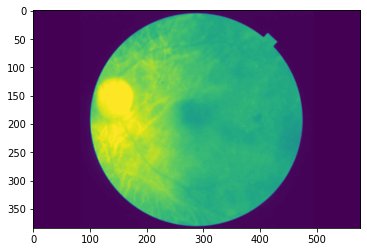

In [9]:
a = iter(test_dl)
b = next(a)
print(b[1])
print(b[0].shape)
plt.imshow(b[0][0][0])

# Evaluation/ Interference

In [10]:
def evaluation(model,test_dl):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    preds = []
    pred_labels = []
    labels = []

            # Disable gradient calculation for validation or inference using torch.no_rad()
    with torch.no_grad():
                for x,y in test_dl:
                    x = x.to(config['device'])
                    y = y.to(config['device']) #CHW --> #HWC
                    valid_logits = model(x)
                    predict_prob = F.softmax(valid_logits)
                    _,predictions = predict_prob.max(1)
                    predictions = predictions.to('cpu')

                    _, valid_preds = torch.max(valid_logits, 1)
                    valid_loss = criterion(valid_logits,y)
                    running_loss += valid_loss.item() * x.size(0)
                    running_corrects += torch.sum(valid_preds == y.data)
                    total += y.size(0)
                    predict_prob = predict_prob.to('cpu')

                    pred_labels.extend(list(predictions.numpy()))
                    preds.extend(list(predict_prob.numpy()))
                    y = y.to('cpu')
                    labels.extend(list(y.numpy()))

    epoch_loss = running_loss / len(test_data)
    epoch_acc = running_corrects.double() / len(test_data)
    print("Test Loss is {}".format(epoch_loss))
    print("Test Accuracy is {}".format(epoch_acc.cpu()))
    return np.array(labels),np.array(pred_labels),np.array(preds)

# Model: Mobilenet V2

In [21]:
def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True))


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def make_divisible(x, divisible_by=8):
    import numpy as np
    return int(np.ceil(x * 1. / divisible_by) * divisible_by)


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

In [22]:
class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_mult=1.):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        assert input_size % 32 == 0
        # input_channel = make_divisible(input_channel * width_mult)  # first channel is always 32!
        self.last_channel = make_divisible(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2)]
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = make_divisible(c * width_mult) if t > 1 else c
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, s, expand_ratio=t))
                else:
                    self.features.append(block(input_channel, output_channel, 1, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        self.features.append(conv_1x1_bn(input_channel, self.last_channel))
        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Linear(self.last_channel, n_class)

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.mean(3).mean(2)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


In [13]:
model = MobileNetV2(width_mult=1)
model.classifier = nn.Linear(in_features = 1280, out_features = 2, bias = True)
model = model.to(config['device'])
model.load_state_dict(torch.load('saved/mob_v2_best.pt'))
optimizer = optim.Adam(model.parameters(),lr=config['lr'])
criterion = nn.CrossEntropyLoss()

In [14]:
labels, pred_labels, preds = evaluation(model,test_dl)

Test Loss is 0.31001701527275144
Test Accuracy is 0.8625


In [18]:
print(metrics.classification_report(labels,pred_labels,target_names = ['abnormal','normal']))
cm = metrics.confusion_matrix(labels,pred_labels)
print('\n classwise accuracy')
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm.diagonal())

print('auc roc score',metrics.roc_auc_score(1-np.array(labels), np.array(preds)[:,0]))

              precision    recall  f1-score   support

    abnormal       0.69      0.63      0.66       134
      normal       0.91      0.92      0.91       506

    accuracy                           0.86       640
   macro avg       0.80      0.78      0.79       640
weighted avg       0.86      0.86      0.86       640


 classwise accuracy
[0.63432836 0.9229249 ]
auc roc score 0.9081912571529704


In [23]:
# Final Trained model
model = MobileNetV2(width_mult=1)
model.classifier = nn.Linear(in_features = 1280, out_features = 2, bias = True)
model = model.to(config['device'])
model.load_state_dict(torch.load('saved/mob_v2.pt'))
optimizer = optim.Adam(model.parameters(),lr=config['lr'])
criterion = nn.CrossEntropyLoss()

In [24]:
labels, pred_labels, preds = evaluation(model,test_dl)

Test Loss is 0.47453446890067424
Test Accuracy is 0.8203125


In [25]:
print(metrics.classification_report(labels,pred_labels,target_names = ['abnormal','normal']))
cm = metrics.confusion_matrix(labels,pred_labels)
print('\n classwise accuracy')
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm.diagonal())

print('auc roc score',metrics.roc_auc_score(1-np.array(labels), np.array(preds)[:,0]))

              precision    recall  f1-score   support

    abnormal       0.56      0.63      0.60       134
      normal       0.90      0.87      0.88       506

    accuracy                           0.82       640
   macro avg       0.73      0.75      0.74       640
weighted avg       0.83      0.82      0.82       640


 classwise accuracy
[0.63432836 0.86956522]
auc roc score 0.857781251843549


# Efficientnet

In [11]:
base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)


class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )

    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4*ceil(int(channels*width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        x = self.pool(self.features(x))
        return self.classifier(x.view(x.shape[0], -1))

## Efficientnet-B0

In [12]:
model = EfficientNet(version = 'b0', num_classes = 2)
model = model.to(config['device'])
model.load_state_dict(torch.load('saved/eff_b0_best.pt'))
optimizer = optim.Adam(model.parameters(),lr=config['lr'])
criterion = nn.CrossEntropyLoss()

In [13]:
labels, pred_labels, preds = evaluation(model,test_dl)

Test Loss is 0.33482994996011256
Test Accuracy is 0.8625


In [14]:
print(metrics.classification_report(labels,pred_labels,target_names = ['abnormal','normal']))
cm = metrics.confusion_matrix(labels,pred_labels)
print('\n classwise accuracy')
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm.diagonal())

print('auc roc score',metrics.roc_auc_score(1-np.array(labels), np.array(preds)[:,0]))

              precision    recall  f1-score   support

    abnormal       0.67      0.67      0.67       134
      normal       0.91      0.91      0.91       506

    accuracy                           0.86       640
   macro avg       0.79      0.79      0.79       640
weighted avg       0.86      0.86      0.86       640


 classwise accuracy
[0.67164179 0.91304348]
auc roc score 0.8966727626688692


In [15]:
# Final Trained model
model = EfficientNet(version = 'b0', num_classes = 2)
model = model.to(config['device'])
model.load_state_dict(torch.load('saved/eff_b0.pt'))
optimizer = optim.Adam(model.parameters(),lr=config['lr'])
criterion = nn.CrossEntropyLoss()

In [16]:
labels, pred_labels, preds = evaluation(model,test_dl)

Test Loss is 1.2293293285901086
Test Accuracy is 0.8171875000000001


In [17]:
print(metrics.classification_report(labels,pred_labels,target_names = ['abnormal','normal']))
cm = metrics.confusion_matrix(labels,pred_labels)
print('\n classwise accuracy')
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm.diagonal())

print('auc roc score',metrics.roc_auc_score(1-np.array(labels), np.array(preds)[:,0]))

              precision    recall  f1-score   support

    abnormal       0.55      0.68      0.61       134
      normal       0.91      0.85      0.88       506

    accuracy                           0.82       640
   macro avg       0.73      0.77      0.74       640
weighted avg       0.83      0.82      0.82       640


 classwise accuracy
[0.67910448 0.85375494]
auc roc score 0.8318830747448528


## Efficientnet-B2

In [25]:
model = EfficientNet(version = 'b2', num_classes = 2)
model = model.to(config['device'])
model.load_state_dict(torch.load('saved/eff_b2_best.pt'))
optimizer = optim.Adam(model.parameters(),lr=config['lr'])
criterion = nn.CrossEntropyLoss()

In [26]:
labels, pred_labels, preds = evaluation(model,test_dl)

Test Loss is 0.3435954756103456
Test Accuracy is 0.8828125


In [27]:
print(metrics.classification_report(labels,pred_labels,target_names = ['abnormal','normal']))
cm = metrics.confusion_matrix(labels,pred_labels)
print('\n classwise accuracy')
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm.diagonal())

print('auc roc score',metrics.roc_auc_score(1-np.array(labels), np.array(preds)[:,0]))

              precision    recall  f1-score   support

    abnormal       0.78      0.61      0.69       134
      normal       0.90      0.95      0.93       506

    accuracy                           0.88       640
   macro avg       0.84      0.78      0.81       640
weighted avg       0.88      0.88      0.88       640


 classwise accuracy
[0.6119403  0.95454545]
auc roc score 0.8886496371895464


In [18]:
# Final trained
model = EfficientNet(version = 'b2', num_classes = 2)
model = model.to(config['device'])
model.load_state_dict(torch.load('saved/eff_b2.pt'))
optimizer = optim.Adam(model.parameters(),lr=config['lr'])
criterion = nn.CrossEntropyLoss()

In [19]:
labels, pred_labels, preds = evaluation(model,test_dl)

Test Loss is 0.34359548036009074
Test Accuracy is 0.8828125


In [20]:
print(metrics.classification_report(labels,pred_labels,target_names = ['abnormal','normal']))
cm = metrics.confusion_matrix(labels,pred_labels)
print('\n classwise accuracy')
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm.diagonal())

print('auc roc score',metrics.roc_auc_score(1-np.array(labels), np.array(preds)[:,0]))

              precision    recall  f1-score   support

    abnormal       0.78      0.61      0.69       134
      normal       0.90      0.95      0.93       506

    accuracy                           0.88       640
   macro avg       0.84      0.78      0.81       640
weighted avg       0.88      0.88      0.88       640


 classwise accuracy
[0.6119403  0.95454545]
auc roc score 0.8886496371895464
